# Twisting of a column with square cross-section

### Units
- Length: mm
- Mass: kg
- Time:  s
- Force: milliNewtons
- Stress: kPa 

### Software:
- Dolfinx v0.8.0


In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/


# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, as_matrix, dot, cos, sin)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# A 3-D beam
L = 3.0 # mm
N =8   
domain = mesh.create_box(MPI.COMM_WORLD, [[-0.5,-0.5,0.0], [0.5, 0.5,L]],\
                         [N,N,4*N], mesh.CellType.hexahedron)

# This says "spatial coordinates" but is really the referential coordinates,
# since the mesh does not convect in FEniCS.
x = ufl.SpatialCoordinate(domain) 

**Identify boundaries of the domain**

In [3]:
# Identify the planar boundaries of the  box mesh
# #
# def xBot(x):
#     return np.isclose(x[0], 0)
# def xTop(x):
#     return np.isclose(x[0], width)
# def yBot(x):
#     return np.isclose(x[1], 0)
# def yTop(x):
#     return np.isclose(x[1], width)
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], L)
    
# Mark the sub-domains
boundaries = [(1,zBot),(2,zTop)]

# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [4]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Surface numbering:
# boundaries = [(1,zBot),(2,zTop)]

[1 2]


**Visualize reference configuration and boundary facets**

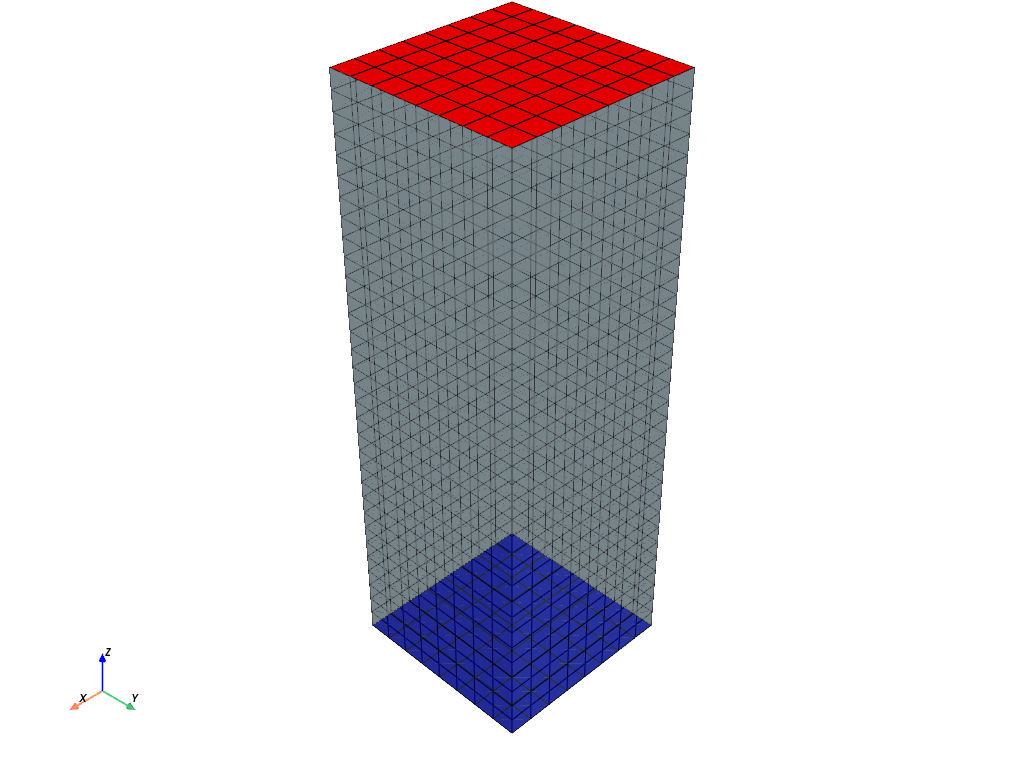

In [18]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh -- I make the 3D mesh opaque, so that 2D surfaces stand out.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.5) 

# Add colored 2D surfaces for the named surfaces
zBot_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==1]) )
zTop_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==2]) )
#
actor = plotter.add_mesh(zBot_surf, show_edges=True,color="blue") # zBot face is blue
actor2 = plotter.add_mesh(zTop_surf, show_edges=True,color="red") # zTop is red

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("mesh.png")

from IPython.display import Image
Image(filename='mesh.png') 

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters
-Arruda-Boyce model

In [7]:
Gshear_0 = Constant(domain,PETSc.ScalarType(280.0))            # Ground state shear modulus
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))             # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000.0*Gshear_0)) 

# Simulation time-control related params

In [8]:
t         = 0.0      # start time (s)
thetaTot = 2 * np.pi
#
Ttot     = 1
numSteps = 50
dt       = Ttot/numSteps      # (fixed) step size

# Function to linearly ramp up displacement on boundary.
def thetaRamp(t):
    return thetaTot*t/Ttot

# Function spaces

In [9]:
# Define function space, both vectorial and scalar
# dolfinx v0.8.0 syntax:   
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For  pressure                                         
#
TH = mixed_element([U2, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w    = Function(ME)
u, p = split(w)  # displacement u, pressure p

# A copy of functions to store values in the previous step
w_old         = Function(ME)
u_old,  p_old = split(w_old)   

# Define test functions        
u_test, p_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Initial conditions

- The initial conditions for degrees of freedom u and p are zero everywhere
- These are imposed automatically, since we have not specified any non-zero initial conditions.

# Subroutines for kinematics and constitutive equations

In [10]:
# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Gshear_AB_calc(u):
    zeta    = zeta_calc(u)
    Gshear  = Gshear_0 * zeta
    return Gshear

#---------------------------------------------
# Subroutine for calculating the Cauchy stress
#---------------------------------------------
def T_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    B = F*F.T
    Bdis = J**(-2/3)*B
    Gshear  = Gshear_AB_calc(u)
    T = (1/J)* Gshear * dev(Bdis) - p * Id
    return T

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    #
    T   = T_calc(u,p)
    #
    Tmat   = J * T * inv(F.T)
    return Tmat

In [ ]:
##A.Flowers Comments

# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F
##Calculation for deformation gradient tensor F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar
##Scalar stretch measure used in hyperelasticity models 

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
##Isochoric stretch from deformation
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
##Normalizes stretch from polymer network
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
##Prevents numeric instability; Langevin function because singular
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
##Pade approximation; used for stability
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta
##Stress scalar from statistical mechanics model for polymers; accounts for finite chain extensibility. Stress tensors for nonlinear chain elasticity

# Generalized shear modulus for Arruda-Boyce model
def Gshear_AB_calc(u):
##Effective shear for nonlinear hyperelastic material
    zeta    = zeta_calc(u)
##Stretch dependent factor using inverse Langevin. Increasing of stretch= polymers stiffen
    Gshear  = Gshear_0 * zeta
    return Gshear
##Shear module grows due to deformation
##This is important due to modeling with biological materials (i.e. tissue); nonlinear and stretch sensitive

#---------------------------------------------
# Subroutine for calculating the Cauchy stress
#---------------------------------------------
def T_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
##Deformation gradient
    J = det(F)
##Jacobian (volume change due to deformation)
    B = F*F.T
##Cauchy-Green tensor
    Bdis = J**(-2/3)*B
##Removes volumetric part to get isochoric (volume perserving aspect)
    Gshear  = Gshear_AB_calc(u)
##Stretch dependent shear
    T = (1/J)* Gshear * dev(Bdis) - p * Id
    return T
##Cauchy stress calculation; shape change and pressure separated to obtain deformed configuration 

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    T   = T_calc(u,p)
    Tmat   = J * T * inv(F.T)
    return Tmat
##Piola stress used in weak form of balance equation, with displacement gradient; defined in terms of reference coordinates

# Evaluate kinematics and constitutive relations

In [11]:
F =  F_calc(u)  
J = det(F)
lambdaBar = lambdaBar_calc(u)

# Piola stress
Tmat = Piola_calc(u, p)

In [ ]:
##A.Flowers Comments

F =  F_calc(u)  
##F= deformation gradient tensor; u= displacement (unkown and solving for)
J = det(F)
##J= Jacobian determinant. Volume change during deformation 
lambdaBar = lambdaBar_calc(u)
##incompressible hyperelasticity; seperates volumetric deviatoric, shape changing parts of deformation. Volume corrected stretch is calculated for use in isochoric strain energy

# Piola stress
Tmat = Piola_calc(u, p)
##Computes Piola stress tensor from displacement field (u) and pressure (p)

# Weak forms

In [12]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)

# The weak form for the balance of forces
Res_0 =  inner(Tmat, grad(u_test) )*dx

# The weak form for the pressure
fac_p = ln(J)/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*dx

# Total weak form
Res = Res_0 +  Res_1 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

In [ ]:
##A.Flowers Comments

# The weak form for the equilibrium equation. No body force
Res_0 = inner(Tmat , grad(u_test) )*dx
##Mechanical residual of weak form for nonlinear elasticity; used to build the residual vector. Used in FE for a deforming solid

# The weak form for the pressure
fac_p = ln(J)/J
##Scalar factor used for compressible / incompressible materials due to pressure / energy in nonlinear elasticity

Res_1 = dot( (p/Kbulk + fac_p), p_test)*dx
##Residual defined for pressure field in FE due to incompressible materials. Differentiates volumetric strain energy

# Total weak form
Res = Res_0 +  Res_1 
##Defines total residual of weak form; from force balance (linear momentum / mechanical equillibrium) and incompressibility (pressure equation)

# Automatic differentiation tangent:
a = derivative(Res, w, dw)
##Jacobian form to solve for nonlinear PDE

# Set-up output files

In [13]:
# results file name
results_name = "3D_column_twisting"

# Function space for projection of results
# v0.8.0 syntax:
U1 = element("DG", domain.basix_cell(), 1, shape=(3,)) # For displacement
P0 = element("DG", domain.basix_cell(), 1)             # For  pressure  

V2 = fem.functionspace(domain, U1) #Vector function space
V1 = fem.functionspace(domain, P0) #Scalar function space

# fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, J_vis, P11, P22, P33, lambdaBar_vis,
        Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)
       
       # Write output fields
       file_results.write(t) 
        

# Name the analysis step

In [14]:
# Give the step a descriptive name
step = "Twist"

## Boundary condtions

In [15]:
# Surface numbering:
# boundaries = [(1,zBot),(2,zTop)]

# Scalar function space corresponding to dispalcement u
V, V_to_ME =  ME.sub(0).collapse() 

# Expression for applied twist
thetaCons = Constant(domain,PETSc.ScalarType(thetaRamp(0)))
Rot = as_matrix([[cos(thetaCons), sin(thetaCons), 0], [-sin(thetaCons), cos(thetaCons), 0], [0, 0, 1]])
rotation_displ = dot(Rot, x) - x
#
# interpolate applied displacement values onto the top surface
u_top = fem.Function(V) 
rot_expr = fem.Expression(rotation_displ, V.element.interpolation_points())
u_top.interpolate(rot_expr)
#
# interpolate zero displacement onto the bottom surface
u_bot = fem.Function(V)
u_bot.interpolate(lambda x: np.stack(( np.zeros(x.shape[1]), np.zeros(x.shape[1]), np.zeros(x.shape[1]) ) ) )

# Bottom  and top surface displacement degrees of freedom
Btm_dofs = fem.locate_dofs_topological((ME.sub(0), V), facet_tags.dim, facet_tags.find(1))
Top_dofs = fem.locate_dofs_topological((ME.sub(0), V), facet_tags.dim, facet_tags.find(2))

# Build the Dirichlet BCs
bcs_1 = dirichletbc(u_bot, Btm_dofs, ME.sub(0))       #  fix   - zBtm
bcs_2 = dirichletbc(u_top, Top_dofs, ME.sub(0))       # twist  - zTop

# collect all BCs in one object.
bcs = [bcs_1, bcs_2]

In [ ]:
##A.Flowers Comments

# Surface numbering:
# boundaries = [(1,zBot),(2,zTop)]

# Scalar function space corresponding to dispalcement u
V, V_to_ME =  ME.sub(0).collapse() 
##ME = mixed function space (product of multiple FE function spaces); holds multiple fields together 
##Collapse = converts subspace of mixed space to independent funtion space
##V = extracted subspace, made independent

# Expression for applied twist
thetaCons = Constant(domain,PETSc.ScalarType(thetaRamp(0)))
##thetaCons = constrant rotation angle defined
##Constant function over domain is applied; specifically used due to FEniCSx expressions.Constant rotation angle defined for time step
Rot = as_matrix([[cos(thetaCons), sin(thetaCons), 0], [-sin(thetaCons), cos(thetaCons), 0], [0, 0, 1]])
##Rot = rotation matrix that can rotate any vector by thetaCons around z-axis
rotation_displ = dot(Rot, x) - x
##For each x point, computes displacement field corresponding to rigid rotation by thetaCons around z-axis

# interpolate applied displacement values onto the top surface
u_top = fem.Function(V) 
##Displacement field over mesh
rot_expr = fem.Expression(rotation_displ, V.element.interpolation_points())
##Points displaced of whole geometry, undergoing rigid rotation angle (thetaCons) around the z-axis
u_top.interpolate(rot_expr)
##Applies torosional deformation; twist at top of cylinder

# interpolate zero displacement onto the bottom surface
u_bot = fem.Function(V)
##Defines displacement function in FEniCSx
u_bot.interpolate(lambda x: np.stack(( np.zeros(x.shape[1]), np.zeros(x.shape[1]), np.zeros(x.shape[1]) ) ) )
##Set to zero displacement in domains; Defines initial / fixed ends of displacement

# Bottom  and top surface displacement degrees of freedom
Btm_dofs = fem.locate_dofs_topological((ME.sub(0), V), facet_tags.dim, facet_tags.find(1))
Top_dofs = fem.locate_dofs_topological((ME.sub(0), V), facet_tags.dim, facet_tags.find(2))
##Fixed bottom surface and applies torosional or pull displacement at the top surface

# Build the Dirichlet BCs
bcs_1 = dirichletbc(u_bot, Btm_dofs, ME.sub(0))       #  fix   - zBtm
bcs_2 = dirichletbc(u_top, Top_dofs, ME.sub(0))       # twist  - zTop
##Applies boundary conditions, fixing bottom surface and enforcing rotational displacement field to top surface

# collect all BCs in one object.
bcs = [bcs_1, bcs_2]
##Applies boundary conditions to the nonlinear solver


## Define the nonlinear variational problem

In [16]:

# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True



#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()



##  Start calculation loop

In [17]:
# Variables for storing time history
totSteps = numSteps+1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 

#Iinitialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0)  

# Print out message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()  

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    thetaCons.value = thetaRamp(t)
    
    # re-interpolate the applied twisting displacements 
    u_top.interpolate(rot_expr)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()   
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Twist | Increment: 1, Iterations: 5
      Simulation Time: 0.02 s  of  1 s

Step: Twist | Increment: 2, Iterations: 5
      Simulation Time: 0.04 s  of  1 s

Step: Twist | Increment: 3, Iterations: 5
      Simulation Time: 0.06 s  of  1 s

Step: Twist | Increment: 4, Iterations: 5
      Simulation Time: 0.08 s  of  1 s

Step: Twist | Increment: 5, Iterations: 5
      Simulation Time: 0.1 s  of  1 s

Step: Twist | Increment: 6, Iterations: 5
      Simulation Time: 0.12 s  of  1 s

Step: Twist | Increment: 7, Iterations: 5
      Simulation Time: 0.14 s  of  1 s

Step: Twist | Increment: 8, Iterations: 5
      Simulation Time: 0.16 s  of  1 s

Step: Twist | Increment: 9, Iterations: 5
      Simulation Time: 0.18 s  of  1 s

Step: Twist | Increment: 10, Iterations: 5
      Simulation Time: 0.2 s  of  1 s

Step: Twist | Increment: 11, Iterations: 5
      Simulation Time: 0.22 s  of  1 s

Step: T